
# Introduction to Advanced Sampling

Ludwig Schneider, Pablo Zubieta, and Juan de Pablo

Pritzker School of Molecular Engineering

The University of Chicago



# Setting up the environment

First, we set up our environment. We will be using a pre-compiled and packaged installation of HOOMD-blue and the hoomd-dlext plugin.
It will be downloaded from Google Drive and made accessible to the Python process running in this Colab instance.


In [ ]:
%%bash

BASE_URL="https://drive.usercontent.google.com/download?id=1hsKkKtdxZTVfHKgqVF6qV2e-4SShmhr7"
COOKIES="/tmp/cookies.txt"
CONFIRMATION="$(wget -q --save-cookies $COOKIES --keep-session-cookies --no-check-certificate $BASE_URL -O- | sed -rn 's/.*confirm=(\w+).*/\1\n/p')"

wget -q --load-cookies $COOKIES "$BASE_URL&confirm=$CONFIRMATION" -O pysages-env.zip
rm -rf $COOKIES

In [ ]:
%env PYSAGES_ENV=/env/pysages

env: PYSAGES_ENV=/env/pysages


In [ ]:
%%bash

mkdir -p $PYSAGES_ENV .
unzip -qquo pysages-env.zip -d $PYSAGES_ENV

In [ ]:
import os
import sys

ver = sys.version_info
sys.path.append(os.environ["PYSAGES_ENV"] + "/lib/python" + str(ver.major) + "." + str(ver.minor) + "/site-packages/")

os.environ["LD_LIBRARY_PATH"] = "/usr/lib/x86_64-linux-gnu:" + os.environ["LD_LIBRARY_PATH"]

We'll also need some additional python dependencies

In [ ]:
!pip install -qq "numpy<2" gsd > /dev/null


## PySAGES

The next step is to install PySAGES. First, we need to install JAX. Fortunately, Colab already ships with JAX pre-installed (to learn how to install it you can look at the [JAX documentation](https://jax.readthedocs.io) for more details). To install PySAGES, we retrieve the latest version from GitHub and add its dependencies via `pip`.


In [ ]:
!pip install -qq git+https://github.com/SSAGESLabs/PySAGES.git > /dev/null


# Advanced Sampling Methods


In [ ]:
%%bash

mkdir /content/advanced_sampling
cd /content/advanced_sampling


Many systems have rugged free-energy landscapes, where different basins are divided by energy barriers.

## Examples

### Collective molecular transitions

- Protein folding
- Protein-ligand binding
- Liquid membrane fusion

<div>
<img src=https://pubs.acs.org/cms/10.1021/ja910050x/asset/images/large/ja-2009-10050x_0008.jpeg width=500>
</div>
<div>
<img src=https://pubs.acs.org/cms/10.1021/ja910050x/asset/images/large/ja-2009-10050x_0011.jpeg width=500>
<div>
Smirnova, Yuliya G., et al. "Solvent-exposed tails as prestalk transition states for membrane fusion at low hydration." Journal of the American Chemical Society 132.19 (2010): 6710-6718


### Phase transitions

- Liquid-vapor transition
- Crystallization
- Shape transitions
- Magnetization (Ising model)

![picture](https://upload.wikimedia.org/wikipedia/commons/e/e6/Ising_quench_b10.gif)

Wikipedia: https://en.wikipedia.org/wiki/Ising_model



## Collective Variables

Also known as order parameters in other contexts.

Usually, such transitions can be described in terms of order parameters/collective variables (CV).

$⇒$ Reduction of the phase space $\hat\xi(\{\vec{r}, \vec{p}\})$. In general, a collective variable can be multi-dimensional.
[Note: the hat "$\hat\ $" indicates that it is a collective variable that explicitly depends on the underlying molecular configuration. Without the "$\hat\ $" it usually indicates a scalar, like a target.]

Examples:

- center of mass of the molecule
- opening angle of protein
- magnetization
- [more common options in PySAGES](https://pysages.readthedocs.io/en/latest/module-pysages-colvars.html)


## Example system: particle in multi-well

Let's start exploring an easy system and find the free-energy landscape.

- a priori $A(\xi)$ is unknown
- but we can measure the density of states $p(\xi)$

We can recover the free-energy profile from $p(\xi)$

$$A = - \frac{1}{\beta}\ln(Z)$$

- $A$: free-energy
- $Z$: NVT partition function

We can formulate the partial partition function for a collective variable $\xi$

$$Z(\xi) = \int\text{d}^N\vec{r}_i\text{d}^N\vec{p}_i \delta (\hat\xi(\{\vec{r}, \vec{p}\} - \xi) e^{-\beta H(\{(\vec{r}_i, \vec{p}_i\})}$$
Normalization:
$$p(\xi) = \frac{\int\text{d}^N\vec{r}_i\text{d}^N\vec{p}_i \delta (\hat\xi(\{\vec{r}, \vec{p}\} -\xi) e^{-\beta H(\{(\vec{r}_i, \vec{p}_i\})}}{\int\text{d}^N\vec{r}_i\text{d}^N\vec{p}_i e^{-\beta H(\{(\vec{r}_i, \vec{p}_i\})}}$$

$$\Rightarrow A(\xi) = -\frac{1}{\beta} \ln(p(\xi)) + C$$
We can determine the free-energy profile $A(\xi)$ from the probability distribution $p(\xi)$.

With regular MC/MD a finite simulation trajectory is confined to a single basin as the probability of leaving the basin scales as

$$p \propto e^{-\beta \Delta E} \ll 1$$

- system might not equilibrate
- trajectory is not ergodic

### Computational realization via a toy system

Let's examine such a system via computer simulations.

- fast to integrate
- custom bond potential to shape the free-energy landscape

$$P(r) = Ar^2 + A(1-e^{-r^2})\cos(r p \pi)$$


In [ ]:
import numpy as np

def energy_and_forces(x, amplitude=1., roughness=5, periodicity=1):
    omega = np.pi * periodicity
    energy = x**2
    energy += (1 - np.exp(-x**2)) * roughness * np.cos(omega * x)
    energy *= amplitude
    forces = 2 * x
    forces -= omega * roughness * (1 - np.exp(-x**2)) * np.sin(omega * x)
    forces += 2 * roughness * np.exp(-x**2) * x * np.cos(omega * x)
    forces *= -amplitude
    return energy, forces

def energy(x, **kwargs):
    return energy_and_forces(x, **kwargs)[0]

def forces(x, **kwargs):
    return energy_and_forces(x, **kwargs)[1]


- customizable roughness and steepness
- symmetric around the origin

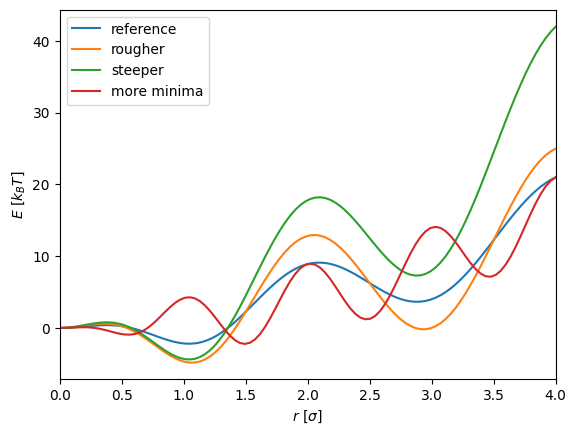

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.set_xlabel(r"$r$ $[\sigma]$")
ax.set_ylabel(r"$E$ $[k_B T]$")
ax.set_xlim((0,4))

x = np.linspace(0,4,100)
ax.plot(x, energy(x), label="reference")
ax.plot(x, energy(x, roughness=9), label="rougher")
ax.plot(x, energy(x, amplitude=2), label="steeper")
ax.plot(x, energy(x, periodicity=2), label="more minima")

# Uncomment to inspect the forces
# ax.plot(x, forces(x), label="analytic force")
# ax.plot(x[:-1], -np.diff(energy(x)) / (x[1] - x[0]), label="numeric force")

ax.legend(loc="best")
fig.show()


- We can choose and adjust the potential

> Here we choose a system with multiple basins separated by energy barriers.

However, the free energy of this system is not the energy of this bond.
Because we are using a distance the system is best described in radial coordinates, which includes the Jacobi determinant $2\pi r^2$ in the weight.

$$p(r) \propto 2\pi r^2 e^{-\beta E(r)}$$

Hence we can obtain the free energy with a logarithmic correction.


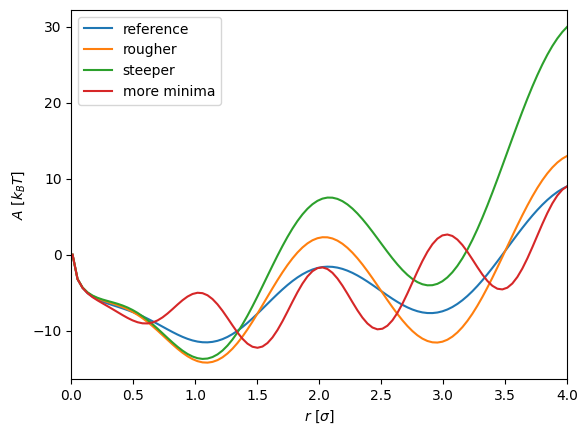

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.set_xlabel(r"$r$ $[\sigma]$")
ax.set_ylabel(r"$A$ $[k_B T]$")
ax.set_xlim((0,4))

def free_energy(energy, kT: float = 1):
    """
    Modifies function energy, such that it returns the free energy
    with the appropriate logarithmic correction.
    """
    beta = 1 / kT
    tau = 2 * np.pi

    def log_corrected_energy(x):
        corrected_energy = beta * energy(x) - np.log(tau * x**2)
        corrected_energy -= corrected_energy[0]
        return corrected_energy

    return log_corrected_energy

x = np.linspace(0.01, 4, 100)
ax.plot(x, free_energy(energy)(x), label="reference")
ax.plot(x, free_energy(lambda x: energy(x, roughness=9))(x), label="rougher")
ax.plot(x, free_energy(lambda x: energy(x, amplitude=2))(x), label="steeper")
ax.plot(x, free_energy(lambda x: energy(x, periodicity=2))(x), label="more minima")

ax.legend(loc="best")
fig.show()


- Notice how the unlikely short distances remove the first minimum around 0
- use of a single bond between two particles to realize the potential in
HOOMD-blue

In [ ]:
import hoomd
import gsd.hoomd

kT = 1
dt = 1e-3
fes_params = dict(amplitude=1, roughness=5, periodicity=1)

def generate_context(kT=kT, dt=dt, fes_params=fes_params, **kwargs):
    """
    Generates a simulation context, we pass this function to the attribute
    `run` of our sampling method.
    """
    sim = hoomd.Simulation(device=hoomd.device.auto_select(), seed=42)

    # System Definition
    snapshot = gsd.hoomd.Frame()

    snapshot.configuration.box = [50, 50, 50, 0, 0, 0]

    snapshot.particles.N = 2
    snapshot.particles.types = ['P', 'G']
    snapshot.particles.typeid = [0, 1]
    snapshot.particles.position = [[3.0,  0,  0], [0, 0, 0]]
    snapshot.bonds.N = 1
    snapshot.bonds.types = ["bond"]
    snapshot.bonds.typeid = [0]
    snapshot.bonds.group = [[0, 1]]

    sim.create_state_from_snapshot(snapshot)
    sim.run(0)

    integrator = hoomd.md.Integrator(dt=dt)

    # Interaction Potential
    r_min, r_max = 0, 10
    n_points = 512
    fes_points = np.linspace(r_min, r_max, n_points)
    energy, forces = energy_and_forces(fes_points, **fes_params)
    fes = hoomd.md.bond.Table(n_points)
    fes.params["bond"] = dict(r_min=r_min, r_max=r_max, U=energy, F=forces)
    integrator.forces.append(fes)

    mobile_particles = hoomd.filter.Type("P")
    langevin = hoomd.md.methods.Langevin(filter=mobile_particles, kT=kT)
    integrator.methods.append(langevin)

    sim.operations.integrator = integrator

    return sim


The bond realizes the custom energy landscape between two particles.
In this case, we can determine the free energy with the Jacobian correction and the bond energy. This is only true because of the simple nature of this toy system. Usually, the free energy is unknown and needs to be discovered via advanced sampling methods.



### Collective variable (order parameter)

Here we choose the distance from the origin as the collective variable.

We use PySAGES to define this collective variable.


In [ ]:
from pysages.colvars import Distance
import pysages

# Distance from our particle to origin (particle 1)
cvs = [Distance([0, 1])]


### Unbiased simulation

Next, we are interested in an unbiased simulation.

PySAGES offers a special method for unbiased simulations, that can record a collective variable.


In [ ]:
from pysages.methods import Unbiased

method = Unbiased(cvs)


We also want to track the collective variable over time and as a histogram, so we can log it via PySAGES.


In [ ]:
from pysages.methods.utils import HistogramLogger

hist = HistogramLogger(period=100)


We now simulate $1\times10^5$ time steps.
To investigate the unbiased trajectory and statistics.


In [ ]:
result = pysages.run(method, generate_context, int(1e5), callback=hist)


Let's see how the particle moved in this potential landscape.


In [ ]:
def plot_cv_trajectory(result, x_range=(0, 4)):
    histogram_log = result.callbacks[0]
    cv_log = np.asarray(histogram_log.data)
    time = np.linspace(0, 0.1 * len(cv_log), len(cv_log))

    x = np.linspace(x_range[0] + 0.01, x_range[1], 200)
    landscape = free_energy(energy)(x)

    fig, ax = plt.subplots()

    ax.set_xlabel(r"$t$ $[\tau]$")
    ax.set_ylabel(r"$\xi$ $[\sigma]$")
    ax.set_ylim(x_range)
    ax.plot(time, cv_log, label="cv trajectory")
    ax.legend(loc="center right")

    ax2 = ax.twiny()
    ax2.set_xlabel(r"$A(\xi)$ $[k_BT]$")
    ax2.plot(landscape, x, label="energy landscape", color="orange")
    ax2.legend(loc="upper left")

    fig.show()

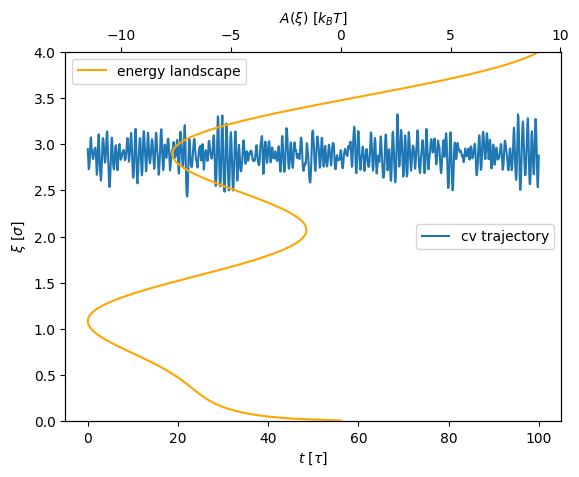

In [ ]:
plot_cv_trajectory(result)


We see, that the system never leaves the local minimum around $\xi=3$.
Since the phase space is not fully explored we would be unable to predict the free energy. Actually, the system is not even equilibrated.

The sampling is not ergodic!
This is common for normal MD (although not as easy to spot usually).



###Solution: Biased simulations

Introducing a weight function $w(\xi(\{r,p\}))$ to allow phase space exploration.

$$p(\{(r,p)\}) \propto p_{eq}(\{r,p\})/w(\xi(\{r, p\}))$$
$p(\{(r,p)\})$ is the biased distribution, $p_{eq}$ refers to the unbiased equilibrium distribution.

Find the biased distribution as a function of the collective variable $\xi$.
$$p(\xi) = \int\text{d}r\text{d}p \delta(\xi - \hat\xi) p(\{(r,p\}))$$
$$p(\xi) = \int\text{d}r\text{d}p \delta(\xi - \hat\xi) \frac{p_{eq}(\{(r,p)\})}{w(\xi)}$$
$$p(\xi) = \frac{1}{w(\xi)} \int\text{d}r\text{d}p \delta(\xi - \hat\xi) p_{eq}(\{(r,p)\})$$
$$p(\xi) = \frac{p_{eq}(\{(r,p)\})}{w(\xi)} $$

- with known distribution $p(\xi)$ (measured) and known weight $w(\xi)$, we can infer $p_{eq}$
- optimal weight $w(\xi) = p_{eq}(\xi)$: almost random walk in $\xi$
- optimal weight a priori unknown

For NVT MD we can modify the Hamiltonian to introduce a weight.
$$p(\{(r,p)\}) \propto e^{-\beta H^0(\{(p,r)\})} \frac{1}{w(\xi(\{(r,p)\}))} = e^{-\beta (H^0(\{(p,r)\})+H^w(\{(r,p)}))$$

$$\Rightarrow H^w(\{(r,p)\} = k_BT \ln(w(\xi(\{(r,p)\})))$$

Here is where [PySAGES](https://github.com/SSAGESLabs/PySAGES) comes into play! PySAGES allows you to easily introduce a biasing Hamiltonian into a given MD backend (like [HOOMD-blue](http://glotzerlab.engin.umich.edu/hoomd-blue/), [OpenMM](https://openmm.org), or [ASE](https://wiki.fysik.dtu.dk/ase/)).
So it is not necessary to modify the MD backend and via [JAX](https://jax.readthedocs.io/en/latest/index.html) we offer automatic differentiation, so forces are calculated automatically.

## Harmonic Biasing

We can start biasing by using a simple harmonic biasing, where we bias the system towards one of the less explored regions in phase space.

$$H^b(r) = \frac{k}{2} (c-r)^2$$

PySAGES offers a pre-defined class that implements this, which we will take advantage of.

In our example toy system, we choose $c=2\sigma$ as a maximum of our external potential.

In [ ]:
from pysages.methods import HarmonicBias

def apply_harmonic_bias(kspring, center=2, cvs=cvs, timesteps=int(1e5), log_period=100):
    method = HarmonicBias(cvs, kspring=kspring, center=center)
    hist = HistogramLogger(period=log_period)
    result = pysages.run(method, generate_context, timesteps, callback=hist)
    return result

We don't know a priori what a good spring constant is. Let's start with $k = 10 \frac{k_BT}{\sigma^2}$, and let's analyze the trajectory as before to see how the energy landscape is explored.

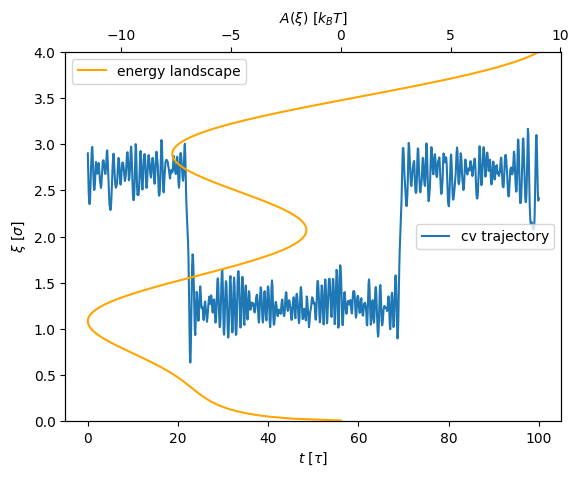

In [ ]:
kspring = 10
result = apply_harmonic_bias(kspring)
plot_cv_trajectory(result)


We observe that the free-energy barrier around $c=2\sigma$ is better explored now, but the biasing force is only strong enough to pull the particle across the barrier a couple of times.

Let's try $k = 100 \frac{k_BT}{\sigma^2} = 10^2 \frac{k_BT}{\sigma^2}$.


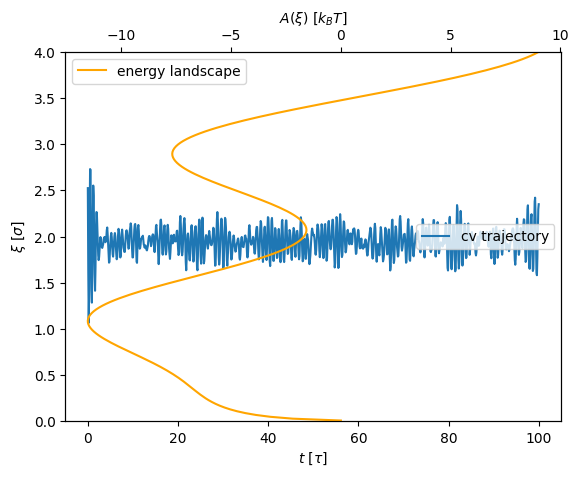

In [ ]:
kspring = 100
result = apply_harmonic_bias(kspring)
plot_cv_trajectory(result)


Ok, now the system mostly oscillates around the local maximum, but is no longer able to come close to the actual minima of the free-energy landscape.

The spring constant is so strong, that restricts the exploration of the phase space too much. Let's try the middle ground instead $k = 30 \frac{k_BT}{\sigma^2} \approx 10^{1.5} \frac{k_BT}{\sigma^2}$.

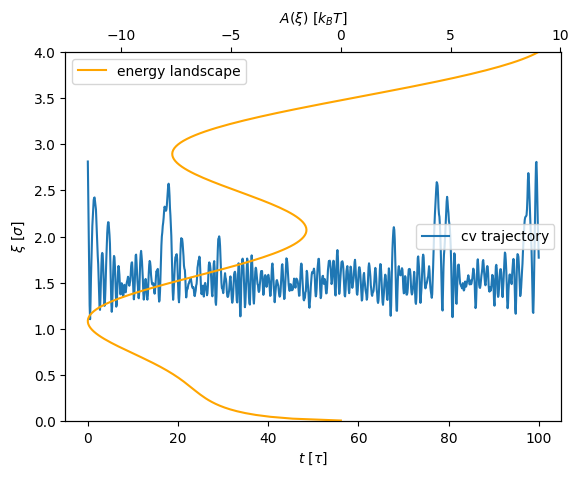

In [ ]:
kspring = 30
result = apply_harmonic_bias(kspring)
plot_cv_trajectory(result)


This looks much better!

We observe multiple transitions between the minima at $c \approx 1\sigma$ and $c \approx 3\sigma$ (which initially where rare events), so the phase space is better explored. We also see that the lower minimum is frequented more than the upper one as expected.

We now analyze the histograms of this trajectory to determine the free-energy landscape $A(\xi)$ from the biased simulation.


In [ ]:
from scipy import integrate

def plot_cv_histogram(result, x_range=(0, 4), bins=30):
    histogram_log = result.callbacks[0]
    hist, edges = histogram_log.get_histograms(bins=bins, range=[x_range])
    x_hist = edges[0][:-1] + np.diff(edges[0]) / 2

    weight = np.exp(-kT * kspring / 2 * (x_hist - 2)**2)
    unbiased_distribution = hist / weight
    unbiased_distribution /= integrate.simpson(unbiased_distribution, x=x_hist)

    fig, ax = plt.subplots()

    ax.set_xlabel(r"$\xi$ $[\sigma]$")
    ax.set_ylabel(r"p(\xi)")
    ax.set_xlim(x_range)
    ax.plot(x_hist, hist, label=r"biased $p(\xi)$")
    ax.plot(x_hist, unbiased_distribution, label=r"unbiased $p_{eq}(\xi)$")
    ax.legend(loc="best")

    fig.show()

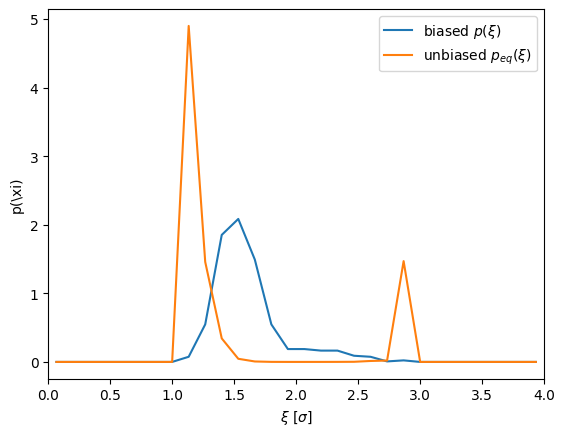

In [ ]:
plot_cv_histogram(result)


We can't be sure that this is the correct profile yet.

So let's compare to the expected free-energy profile.

$$A(\xi) = -k_BT \ln\left( p_{eq}(\xi) \right) + C$$


In [ ]:
def plot_free_energy(result, x_range=(0, 4), bins=30):
    x = np.linspace(x_range[0] + 0.01, x_range[1], 200)
    corrected_free_energy = free_energy(energy)(x)

    histogram_log = result.callbacks[0]
    hist, edges = histogram_log.get_histograms(bins=bins, range=[x_range])
    x_hist = edges[0][:-1] + np.diff(edges[0]) / 2

    weight = np.exp(-kT * kspring / 2 * (x_hist - 2)**2)
    unbiased_distribution = hist / weight
    unbiased_distribution /= integrate.simpson(unbiased_distribution, x=x_hist)

    mask = unbiased_distribution != 0
    estimated_profile = -kT * np.log(unbiased_distribution[mask])
    constant_C = -np.min(estimated_profile) + np.min(corrected_free_energy)

    fig, ax = plt.subplots()
    ax.set_xlabel(r"$\xi$ $[\sigma]$")
    ax.set_ylabel(r"A(\xi)")
    ax.set_xlim(x_range)

    ax.plot(x, corrected_free_energy, label=r"true $A(\xi)$")
    ax.plot(x_hist[mask], estimated_profile + constant_C, label=r"estimated $A(\xi)$")

    ax.legend(loc="best")
    fig.show()

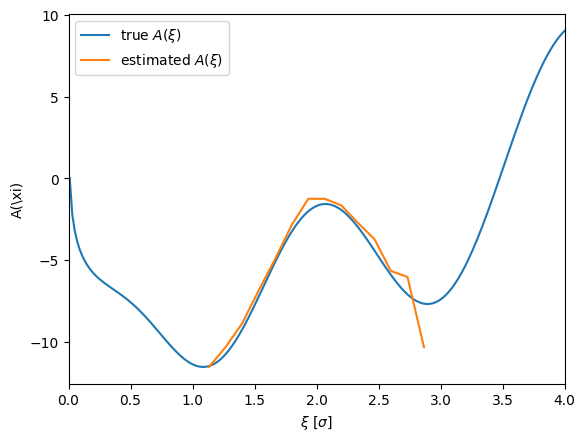

In [ ]:
plot_free_energy(result)

That estimation is not bad.
We get the approximate right shape in the middle and that could be further improved by running the sampling trajectory longer. Or try a different spring constant. [Try it out!]

But there are still some issues because we still cannot sample the entire space:

- the right and left barriers are uncovered
- the height and maximum of the sampled barrier are slightly off
- the highest local minimum is under-sampled

Can we bias simulations in these regions too, to improve sampling coverage?

## Umbrella Sampling

We want to find the free-energy profile along a given path in the space for collective variables. Usually, this path can be multidimensional.

Example dihedral angles of Alanine Dipeptide. [PySAGES Alanine Dipeptide examples](https://colab.research.google.com/github/SSAGESLabs/PySAGES/blob/main/examples/openmm/Harmonic_Bias.ipynb)

<img src=https://cdn.ncbi.nlm.nih.gov/pmc/blobs/a1dd/4715807/e8dece12c024/nihms-706794-f0001.jpg width=500>

Wu, Xiongwu, Bernard R. Brooks, and Eric Vanden‐Eijnden. Journal of computational chemistry 37.6 (2016): 595-601.

<img src=https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fsrep31232/MediaObjects/41598_2016_Article_BFsrep31232_Fig4_HTML.jpg width=500>

Bonomi, Massimiliano, Carlo Camilloni, and Michele Vendruscolo. Scientific reports 6.1 (2016): 1-11.

Downside:

We need to know the path $\xi_0(t)$ we are interested in.

Goal:

Obtain the free-energy profile along the path $A(\xi_0(t))$.



Discretize the path $\xi_0(t_i)$ and bias the simulation at each point $i$ along the path.

$$H_i(\{(r)\}) = H^0(\{(r)\}) + H^b_{i}(\xi(\{(r)\}))$$

$H^b_{i}$ biases the system close to $\xi_0(t_i)$ along the path.

$$p_i^u(\xi) = \frac{\int\text{d}r e^{-\beta H(r)} \delta(\hat\xi(r) - \xi)}{\int\text{d}r e^{-\beta H(r)}}$$

$$p_i^b(\xi) = \frac{\int\text{d}r e^{-\beta[H(r) + H^b_{i}(\hat\xi(r))]} \delta(\hat\xi(r) - \xi)}{\int\text{d}r e^{-\beta[H(r) + H^b_{i}(\hat\xi(r))]}}$$

$$ = e^{-\beta H^b*{i}(\xi)} \frac{\int\text{d}r e^{-\beta H(r)} \delta(\hat\xi(r) - \xi)}{\int\text{d}r e^{-\beta[H(r) + H^b*{i}(\hat\xi(r))]}}$$

$$\Rightarrow p_i^u(\xi) = p_i^b(\xi) e^{\beta H^b_{i}(\xi)} \frac{\int \text{d} r e^{-\beta H^b_{i}(\xi(r))} e^{-\beta H(r)}}{\int\text{d}r e^{-\beta H(r)}}$$

So we can describe the last term as a thermal average.

$$\Rightarrow p_i^u(\xi) = p_i^b(\xi) e^{\beta H^b_{i}(\xi)} \langle e^{-\beta H^b_{i}}\rangle$$

And the free energy is

$$A_i(\xi) = -k_BT \ln(p_i^b(\xi)) - H^b_{i}(\xi) + F_i$$
With $F_i = -k_BT\ln(\langle e^{-\beta H^b_{i}}\rangle)$ as constant independent of $\xi$.

With a single biasing potential $F_i$ does not matter. $A(\xi)$ is defined up to a constant.

But if we want to combine multiple windows, we have to estimate it.

$$e^{-\beta F_i} = \langle e^{-\beta H^b_{i}}\rangle$$
$$ = \int \text{d} \xi p^u(\xi) e^{-\beta H^b*{i}(\xi)}$$
$$ = \int\text{d}\xi e^{-\beta [A(\xi) + H^b*{i}(\xi)}$$

not directly solvable.

### Shape of the potential

Ideal $e^{-\beta H^b_{i}}(\xi) \propto p_{eq}(\xi)$ and differentiable.

- For now we use a harmonic potential
- fix the system with a spring to point on the path.
  $$H^b_{i}(\xi) = k/2 (\xi - \xi_0(t_i))^2$$
- combine different points into one analysis

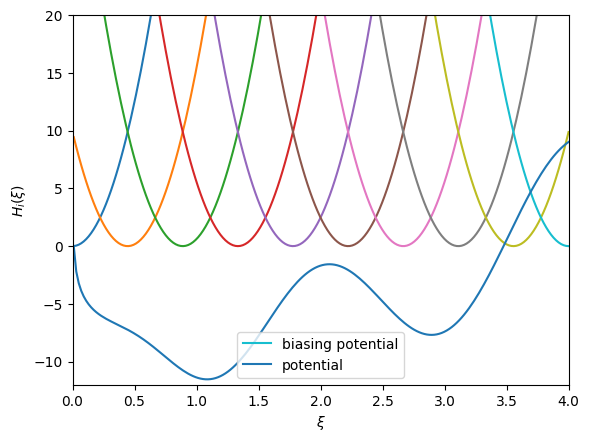

In [ ]:
centers = np.linspace(0, 4, 10)
kspring = 100

x = np.linspace(0.01, 4, 200)
landscape = free_energy(energy)(x)

fig, ax = plt.subplots()

ax.set_xlabel(r"$\xi$")
ax.set_ylabel(r"$H_i(\xi)$")
ax.set_ylim((-12, 20))
ax.set_xlim((0, 4))

for x_c in centers:
    label = "biasing potential" if x_c == 4 else None
    ax.plot(x, kspring / 2 * (x - x_c)**2, label=label)

ax.plot(x, landscape, label="potential")
ax.legend(loc="best")

fig.show()


- one free parameter per window $k$
  Goal: $\Rightarrow$ overlapping histograms

$$\int \text{d} \xi p_i^b(\xi) p_{i+1}^b(\xi) \gg 0$$


In [ ]:
from pysages.methods import UmbrellaIntegration

method = UmbrellaIntegration(cvs, kspring, centers, 100)
result = pysages.run(method, generate_context, int(1e5))


You can already see one downside, we have to run multiple replicas, which consume more computational resources.

Let's see what the histograms look like.


In [ ]:
def plot_multi_histogram(result, x_range=(0, 4), bins=30):
    xs = []
    histograms = []

    for histogram_log in result.callbacks:
        hist, edges = histogram_log.get_histograms(bins=bins, range=[x_range])
        xs.append(edges[0][:-1] + np.diff(edges[0]) / 2)
        histograms.append(hist)

    fig, ax = plt.subplots()

    ax.set_xlabel(r"$\xi$ $[\sigma]$")
    ax.set_ylabel(r"p(\xi)")
    ax.set_xlim(x_range)

    for x, hist in zip(xs, histograms):
        ax.plot(x, hist, label=r"biased $p(\xi)$")

    fig.show()

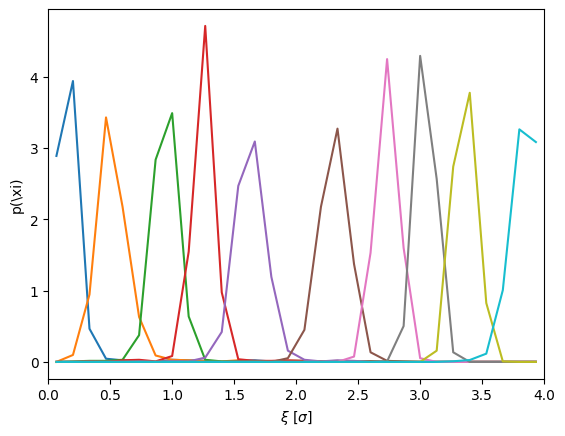

In [ ]:
plot_multi_histogram(result)


The result is OK, good enough for our test case here. We have some overlap between the histograms.

### Umbrella Integration

Now, how can we combine these histograms into a single free-energy profile?

$$A_i(\xi) = -k_BT \ln(p_i^b(\xi)) - H^b_{i}(\xi) + F_i$$

One option is weighted histogram analysis (WHAM), but that works best for one-dimensional collective variables. (Implement it yourself, all you need from PySAGES is available.)

Here we are using a simple umbrella integration instead.

Idea: differentiate by $\xi$ to eliminate $F_i$.

$$\frac{\partial A_i^u}{\partial \xi} = - k_BT \frac{\partial \ln(p_i^b(\xi))}{\partial \xi} - \frac{\partial H^b_{i}(\xi)}{\partial \xi}$$

For this we approximate $p_i^b(\xi)$ as a Gaussian with the mean $\bar\xi_i$ and variance $\sigma_i^b$.

$$p_i^b(\xi) = \frac{1}{\sigma_i^b \sqrt{2\pi}} e^{-\frac{1}{2} \frac{(\xi-\xi_i^b)^2}{\sigma_i^{b2}}}$$

approximating up to second order gives us

$$\frac{\partial A_i^u}{\partial \xi} = - k_BT \frac{\xi-\bar\xi_i}{\sigma_i^{b2}} - k_i (\xi - \xi_0(t_i)).$$
We can also approximate up to first order only
$$\frac{\partial A_i^u}{\partial \xi} =  k_i (\xi - \xi_0(t_i)),$$
which is easily expandable to higher order collective variables and the implementation in PySAGES.

Now we can combine all these windows

$$\frac{\partial A}{\partial \xi} = \sum_i p_i(\xi) \frac{\partial A_i^u}{\partial \xi}$$
with
$$p_i(\xi) = \frac{a_i(\xi)}{\sum_j a_j(\xi)}$$
and
$$a_i(\xi) = N_i p_i^b(\xi)$$
with $N_i$ being the number of samples in window $i$.

And integrate the derivative for the profile numerically.

- this averages the mean-force
- we are approximating the distribution
- easy to generalize in higher dimensions

Let's see how PySAGES analyzes it for us and produces the free-energy result.


In [ ]:
def plot_umbrella_free_energy(pre_result, x_range=(0, 4)):
    x = np.linspace(x_range[0] + 0.01, x_range[1], 50)
    landscape = free_energy(energy)(x)

    result = pysages.analyze(pre_result)
    centers = np.asarray(result["centers"])[:, 0]
    estimate = np.asarray(result["free_energy"])
    estimate = estimate - np.min(estimate) + np.min(landscape)

    fig, ax = plt.subplots()

    ax.set_xlabel(r"$\xi$ $[\sigma]$")
    ax.set_ylabel(r"A(\xi)")
    ax.set_xlim(x_range)
    ax.plot(x, landscape, label=r"true $A(\xi)$")
    ax.plot(centers, estimate, label=r"estimated $A(\xi)$")
    ax.legend(loc="best")

    fig.show()

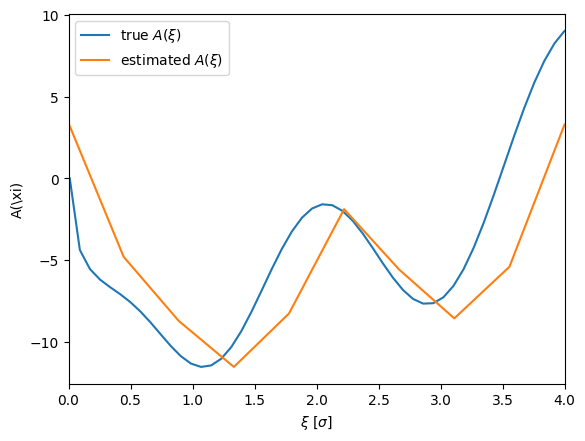

In [ ]:
plot_umbrella_free_energy(result)

Even with the crude finite-differences approximations we are doing we can estimate the shape of the potential.

Just the second minimum is underestimated, which could be fixed with more sampling and more sampling points in that vicinity. [Try it out!]

Difficulties:

1.  choose a good spring constant
    - if it is too large, the histograms won't overlap
    - if it too small, you won't be able to sample some barriers
2.  choose a good number of replicas

Can we do better than this?
Yes, of course:

- [Meta-dynamics](https://colab.research.google.com/github/SSAGESLabs/PySAGES/blob/main/examples/hoomd-blue/Umbrella_Integration.ipynb): approximate one weight function with a sum of Gaussians
- [ANN](https://colab.research.google.com/github/SSAGESLabs/PySAGES/blob/main/examples/hoomd-blue/Butane_ANN.ipynb): approximate biasing force with artificial neuronal networks (ANN)
- And many more sampling methods implemented in PySAGES

## GPU computing

This example was using a single CPU core only.
For a realistic system, GPU acceleration is required.

What do we have to do to run this code on a GPU?

Nothing!

Just change the runtime environment to GPU and you are good to go.
Or run your examples on the GPU accelerated workstation.

PySAGES is preinstalled, so you are good to go!



## String algorithm

We can determine the profile of free energy now.
In more than one dimension the profile depends on the path taken.

<img src=https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fsrep31232/MediaObjects/41598_2016_Article_BFsrep31232_Fig4_HTML.jpg width=500>

Bonomi, Massimiliano, Carlo Camilloni, and Michele Vendruscolo. Scientific reports 6.1 (2016): 1-11.

So how do we find the minimum (free) energy path (MEP)?

This path runs through a valley of the free-energy landscape and has the smallest free-energy barrier. Hence it is the most likely kinetic path.

The formal definition of this path is that the forces on a state point are always parallel (up or down not sideways) to the path.

$$\xi_0(t) \parallel \Delta V$$
The normal component of the force $\Rightarrow \Delta V^\perp = 0$ is zero.

General Idea:

Move the string (path) along the perpendicular component $\Delta V^\perp$ at each discretized point $v_i = - \Delta V^\perp$. (Gradient descent)
The parallel component would move the discretized point just along the path and end up in a minimum.

Problem 1:

How to get $\Delta V$? [Especially if it is a free-energy]

Solution: Harmonic biased simulations at each replica of the string

$$\Delta V|_{t_i} = - k \langle \xi_0(t_i) - \xi \rangle$$

[computationally expensive]

Problem 2:

How to get the perpendicular component?

- the discretization of the path is rough

Solution: use a cubic spline-interpolation

- piece-wise 3rd order polynomial
- easy to parameterize
- easy to interpolate
- differentiable

$\Rightarrow$ perpendicular component $\Delta V^\perp$!
$\Rightarrow$ smooth path $\xi_0^s(t)$ with $\xi_0^s(t) = \xi(t_i)$.

### Improved string method

Using the perpendicular component directly does not lead to good convergence.
Instead, we can use the improved string method.

Iterate:

1.  Calculate $\Delta V|_{t_i}$
2.  Move string $\xi_0(t_i)$ += $\alpha \Delta V|_{t_i}$
3.  Calculate spline $\xi_0^s(t)$
4.  Re-parametrize the string points such that $|\xi_0^s(t_i) - \xi_0^s(t_{i+1})| = const$.
    - cancels out parallel force component
    - well-discretized string
    - requires a norm in $\xi$ space. For example $L^2$ norm in $\xi$ space.

Stop iteration if converged and test $\Delta V^\perp = 0$.

- typically slow convergence

With the converged path, calculate the free-energy profile using umbrella integration.

## What is a good collective variable?

Let us define a committor probability.

For a given point $r_i$ we can define the probability that a simulation started from this point ends in minimum $B$ first before it moves through $B$.
$$\text{commitor probability B: } p_B(r_i)$$

This is a probability since we can have multiple realizations of $r_i$ in momentum space (Maxwell-Boltzmann distribution). Each of these realizations has its path and we simulate them and measure if they arrive in $A$ or $B$ first.

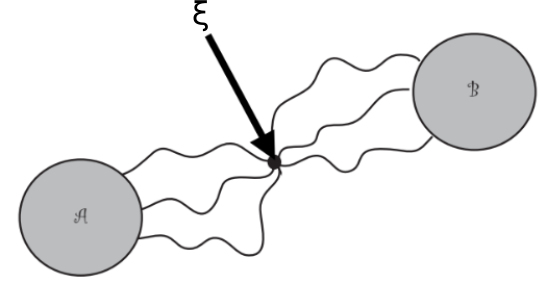



Intuitively, if $\xi$ is at the halfway point of the path ($t=1/2$) the committor probability should be $1/2$.
And the probability decreases if we move towards $A$ ($t < 1/2$) the probability should also decrease $p_B(t < 1/2) < 1/2$ and vice versa $p_B(t>1/2) > 1/2$.


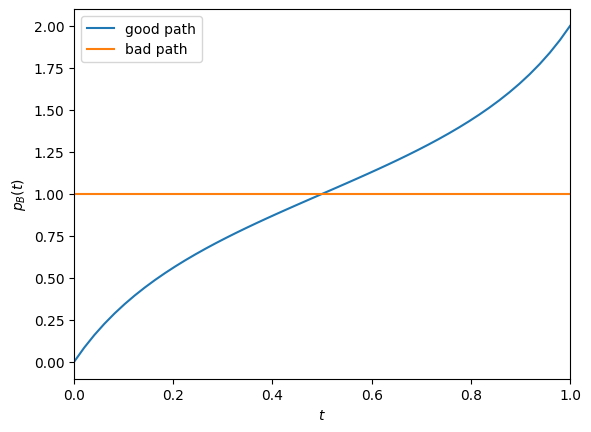

In [ ]:
fig, ax =plt.subplots()
ax.set_xlabel("$t$")
ax.set_xlim((0,1))
ax.set_ylabel("$ p_B(t)$")

x = np.linspace(0, 1, 50)
p_good = np.tan(2*(x-.5))
p_good -= np.min(p_good)
p_good /= integrate.simpson(p_good, x=x)
p_bad = x*0+1
p_bad /= integrate.simpson(p_bad, x=x)

ax.plot(x, p_good, label="good path")
ax.plot(x, p_bad, label="bad path")

ax.legend(loc="best")
fig.show()


We can generalize this concept to the entire space.

First, the isosurfaces of the collective variable are all points in space $(r,p)$ where $\xi((r,p))=c$ are equal and $c$.
In our example, the sphere around the origin with distance $c=0.5$.

We can also define isosurfaces for the committor probabilities.
All points in space where the committor probabilities are equal $p_B(r_i) =c$.

For a descriptive collective variable, we want that when changing $\xi$ the committor probability changes equally.
This is best ensured if the isosurfaces of the collective variables are aligned with the isosurfaces of committor probabilities.

Usually, calculating committor probabilities is computationally so expensive that it is prohibitive. But it is a way to check results in case of doubt about collective variables.



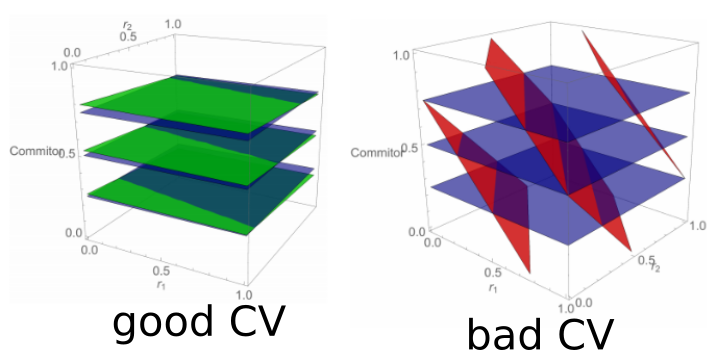
